# Etude des évolutions des prix dans le 91 entre 2018 et 2022

Dans ce Notebook, sera présenté 3 parties. Une première sur la fonction permettant de trier les dataframes de mutation entre 2018 et 2022 et leur application sur les dataframes. Une deuxième sur les évolution des prix en Essonne. Enfin, une dernière sur les évolution des prix à Massy une ville du 91. 

In [3]:
import pandas as pd
import gzip
import matplotlib.pyplot as plt
import seaborn as sns

## I- Tri et gestion des dataframes

Fonction de tri et de gestion des valeurs manquantes, la recherche de cette fonction est préciser dans le notebook *Préparation des données* 

In [11]:
def TriDataFrameVente91(fichier_gz):
    '''
    Fonction permettant d'extraire et de trier les données d'un dataframe pour le departement Essonne (91)
    
    Argument: fichier_gz : le chemin d'un fichier .csv.gz
    
    Retourne: 2 dataframes
                df_maisons: Dataframe contenant les maisons
                df_appartements: Dataframe contenant les appartements
    
    '''
    # Décompression et lecture du fichier CSV avec Pandas
    with gzip.open(fichier_gz, 'rt') as f:
        dataframe = pd.read_csv(f, encoding='utf-8')
   
    #Selection des colonnes
    df = dataframe[['id_mutation','date_mutation','nature_mutation',
               'valeur_fonciere','code_commune','nom_commune','code_departement',
               'id_parcelle','code_type_local','type_local','surface_reelle_bati',
               'nombre_pieces_principales','code_nature_culture','nature_culture',
               'code_nature_culture_speciale','nature_culture_speciale','surface_terrain',
               'longitude','latitude']]

    #Selection du département de l'Essonne
    df = df[df.code_departement == 91]

    #Création d'un booléen pour savoir si un acte contient plusieurs biens
    df['mutation'] = df['id_mutation'].duplicated(keep=False)

    #Suppresion des lignes dont il manque la valeur fonciere
    df = df.dropna(axis = 0, subset = 'valeur_fonciere')

    #Remplacement des valeurs manquantes pour le terrains vides
    condition = (df['code_nature_culture'].notna())|(df['code_nature_culture_speciale'].notna()|df['mutation'])

    df.loc[condition, ['code_type_local','surface_reelle_bati','nombre_pieces_principales']] = df.loc[condition, ['code_type_local','surface_reelle_bati','nombre_pieces_principales']].fillna(0)
    df.loc[condition, ['type_local']] = df.loc[condition, ['type_local']].fillna('Vide')

    #Remplacement des valeurs manquantes pour les terrains sans cultures
    condition = (df['code_nature_culture_speciale'].notna())|(df['code_type_local'].notna()|df['mutation'])

    df.loc[condition, ['code_nature_culture']] = df.loc[condition, ['code_nature_culture']].fillna('PDC')
    df.loc[condition, ['nature_culture']] = df.loc[condition, ['nature_culture']].fillna('pas de cultures')

    #Remplacement des valeurs manquantes pour les terrains sans cultures spéciales
    condition = (df['code_nature_culture'].notna())|(df['code_type_local'].notna()|df['mutation'])

    df.loc[condition, ['code_nature_culture_speciale']] = df.loc[condition, ['code_nature_culture_speciale']].fillna('PDCS')
    df.loc[condition, ['nature_culture_speciale']] = df.loc[condition, ['nature_culture_speciale']].fillna('Pas de Cultures Spé')

    #Remplacement des valeurs manquantes des surfaces de terrains pour les appartements, les dépendances et les locaux  autres (entreprises, entrepots..)
    df.loc[(df['code_type_local'] == 2)|(df['code_type_local'] == 3)|(df['code_type_local'] == 4), ['surface_terrain']] = df.loc[(df['code_type_local'] == 2)|(df['code_type_local'] == 3)|(df['code_type_local'] == 4), ['surface_terrain']].fillna(0)

    #Suppression des valeurs manquantes restantes
    df = df.dropna()

    #Création du dataframe par regroupement sur les différents biens par mutation
    df = df.groupby(['id_mutation']).agg(date_mutation = ('date_mutation', 'first'),
                                         nb_elements = ('id_mutation', 'count'),
                                         nature_mutation = ('nature_mutation', 'first'),
                                         valeur_fonciere = ('valeur_fonciere', 'first'),
                                         code_commune = ('code_commune', 'first'),
                                         nom_commune = ('nom_commune', 'first'),
                                         code_departement = ('code_departement', 'first'),
                                         surface_reelle_bati = ('surface_reelle_bati', 'sum'),
                                         nombre_pieces_principales = ('nombre_pieces_principales', 'sum'),
                                       somme_terrain = ('surface_terrain', lambda x: sum(set(x))),
                                       l_surface_terrain = ('surface_terrain', set),
                                       nb_parcelles = ('id_parcelle', 'nunique'),
                                       local_maison = ('code_type_local', lambda x: (x == 1).sum()),
                                       local_appartement = ('code_type_local', lambda x: (x == 2).sum()),
                                       local_dependance = ('code_type_local', lambda x: (x == 3).sum()),
                                       local_terrain = ('code_type_local', lambda x: (x == 0).sum()),
                                       local_industriel = ('code_type_local', lambda x: (x == 4).sum()),
                                       l_code_nature_culture = ('code_nature_culture', set),
                                       l_code_nature_culture_speciale = ('code_nature_culture_speciale', set),
                                         longitude = ('longitude', 'first'),
                                         latitude = ('latitude', 'first')
                                        )

    #Séparation en deux dataframes pour des mutation ne contenant que un appartement ou(exclusif) une maison
    df_maisons = df[(df['local_maison'] == 1) & (df['local_appartement'] == 0) & (df['local_industriel'] == 0) & (df['nature_mutation'] == 'Vente')]
    df_appartements = df[(df['local_maison'] == 0) & (df['local_appartement'] == 1) & (df['local_industriel'] == 0) & (df['nature_mutation'] == 'Vente')]

    df_maisons = df_maisons[['date_mutation', 'nb_elements', 'valeur_fonciere', 
                             'code_commune', 'nom_commune', 'surface_reelle_bati',
                            'somme_terrain', 'local_dependance', 'local_terrain','nombre_pieces_principales', 
                            'l_code_nature_culture', 'l_code_nature_culture_speciale', 'longitude', 'latitude']]

    df_appartements = df_appartements[['date_mutation', 'nb_elements', 'valeur_fonciere', 
                             'code_commune', 'nom_commune', 'surface_reelle_bati',
                            'somme_terrain', 'local_dependance', 'local_terrain', 'nombre_pieces_principales', 
                            'l_code_nature_culture', 'l_code_nature_culture_speciale', 'longitude', 'latitude']]

    #Tri par code communes des dataframes
    df_maisons = df_maisons.sort_values(by='code_commune')
    df_appartements = df_appartements.sort_values(by='code_commune')

    #Ajout de la colonne du prix au m2
    df_maisons['prix_m_carre'] = df_maisons['valeur_fonciere']/df_maisons['surface_reelle_bati']
    df_appartements['prix_m_carre'] = df_appartements['valeur_fonciere']/df_appartements['surface_reelle_bati']

    #Ajout de la colonne prix moyen par ville pour les appartements
    prix_ville = df_appartements.groupby('code_commune')['valeur_fonciere'].sum()
    mcarre_ville = df_appartements.groupby('code_commune')['surface_reelle_bati'].sum()
    ville = df_appartements['nom_commune'].unique()

    prix_mcarr_ville = pd.DataFrame({'nom_commune': ville, 
                                 'prix_ville': prix_ville.values,
                                 'surface_ville' : mcarre_ville.values
                                })

    prix_mcarr_ville['prix_mcarr_moy_ville'] = prix_mcarr_ville['prix_ville']/prix_mcarr_ville['surface_ville']

    prix_mcarr_ville = prix_mcarr_ville[['nom_commune', 'prix_mcarr_moy_ville']]

    df_appartements = df_appartements.merge(prix_mcarr_ville, on = 'nom_commune', how = 'left')
    
    
    
    #Ajout de la colonne prix moyen par ville pour les maisons
    prix_ville = df_maisons.groupby('code_commune')['valeur_fonciere'].sum()
    mcarre_ville = df_maisons.groupby('code_commune')['surface_reelle_bati'].sum()
    ville = df_maisons['nom_commune'].unique()

    prix_mcarr_ville = pd.DataFrame({'nom_commune': ville, 
                                 'prix_ville': prix_ville.values,
                                 'surface_ville' : mcarre_ville.values
                                })

    prix_mcarr_ville['prix_mcarr_moy_ville'] = prix_mcarr_ville['prix_ville']/prix_mcarr_ville['surface_ville']

    prix_mcarr_ville = prix_mcarr_ville[['nom_commune', 'prix_mcarr_moy_ville']]
    
    df_maisons = df_maisons.merge(prix_mcarr_ville, on = 'nom_commune', how = 'left')
   
    return  df_maisons, df_appartements



Récuperation des dataframes et application de la fonction précédente

In [25]:
df_maisons_2021, df_appartements_2021 = TriDataFrameVente91(r'../data/full2021.csv.gz')

C:\Users\julie\AppData\Local\Temp\ipykernel_5460\2667234663.py:14: DtypeWarning: Columns (10,12,14,17,18,20,22,24,35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframe = pd.read_csv(f, encoding='utf-8')


In [12]:
df_maisons_2022, df_appartements_2022 = TriDataFrameVente91(r'../data/full2022.csv.gz')

C:\Users\julie\AppData\Local\Temp\ipykernel_3428\3182712783.py:14: DtypeWarning: Columns (10,12,14,16,17,18,20,22,35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframe = pd.read_csv(f, encoding='utf-8')


In [13]:
df_appartements_2022.head()

,date_mutation,nb_elements,valeur_fonciere,code_commune,nom_commune,surface_reelle_bati,somme_terrain,local_dependance,local_terrain,nombre_pieces_principales,l_code_nature_culture,l_code_nature_culture_speciale,longitude,latitude,prix_m_carre,prix_mcarr_moy_ville
0,2022-09-20,2,137000.0,91016,Angerville,85.0,0.0,1,0,3.0,{PDC},{PDCS},1.999966,48.314096,1611.764706,1923.344948
1,2022-02-10,1,81000.0,91016,Angerville,35.0,0.0,0,0,2.0,{PDC},{PDCS},1.998827,48.310925,2314.285714,1923.344948
2,2022-10-27,2,150000.0,91016,Angerville,80.0,0.0,1,0,3.0,{PDC},{PDCS},1.991374,48.317805,1875.000000,1923.344948
3,2022-05-10,2,52000.0,91016,Angerville,35.0,61.0,0,1,3.0,{S},{PDCS},1.998949,48.311124,1485.714286,1923.344948
4,2022-09-16,2,132000.0,91016,Angerville,52.0,0.0,1,0,2.0,{PDC},{PDCS},1.999966,48.314096,2538.461538,1923.344948


Sauvegarde de ces dataframes, l'un pour le notebook *Entrainement sur les maisons du 91*, l'autre pour le notebook *Entrainement sur les appartements du 91*

In [14]:
nom_fichier = r'../data/df_maisons_2022_91.csv'
df_maisons_2022.to_csv(nom_fichier, index=False)

In [15]:
nom_fichier = r'../data/df_appartements_2022_91.csv'
df_appartements_2022.to_csv(nom_fichier, index=False)

In [27]:
df_maisons_2020, df_appartements_2020 = TriDataFrameVente91(r'../data/full2020.csv.gz')

C:\Users\julie\AppData\Local\Temp\ipykernel_5460\2667234663.py:14: DtypeWarning: Columns (10,12,14,16,17,18,20,22,35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframe = pd.read_csv(f, encoding='utf-8')


In [28]:
df_maisons_2019, df_appartements_2019 = TriDataFrameVente91(r'../data/full2019.csv.gz')

C:\Users\julie\AppData\Local\Temp\ipykernel_5460\2667234663.py:14: DtypeWarning: Columns (10,12,14,16,17,18,20,22,35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframe = pd.read_csv(f, encoding='utf-8')


In [29]:
df_maisons_2018, df_appartements_2018 = TriDataFrameVente91(r'../data/full2018.csv.gz')

C:\Users\julie\AppData\Local\Temp\ipykernel_5460\2667234663.py:14: DtypeWarning: Columns (8,10,12,14,16,17,18,20,22,26,35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframe = pd.read_csv(f, encoding='utf-8')


Concaténation des dataframes sur les maisons vendues

In [30]:

dataframes = [df_maisons_2018, df_maisons_2019, df_maisons_2020, df_maisons_2021, df_maisons_2022]

df_maisons = pd.concat(dataframes, ignore_index=True)
df_maisons['date_mutation'] = pd.to_datetime(df_maisons['date_mutation'], format='%Y-%m-%d', errors='coerce')   
df_maisons['year'] = df_maisons['date_mutation'].dt.year
df_maisons.head()

,date_mutation,nb_elements,valeur_fonciere,code_commune,nom_commune,surface_reelle_bati,somme_terrain,local_dependance,local_terrain,nombre_pieces_principales,l_code_nature_culture,l_code_nature_culture_speciale,prix_m_carre,prix_mcarr_moy_ville,year
0,2018-10-23,3,145000.0,91001,AbbÃ©ville-la-RiviÃ¨re,60.0,1901.0,0,2,5.0,"{S, J}","{PDCS, POTAG}",2416.666667,2372.95082,2018
1,2018-10-17,2,144500.0,91001,AbbÃ©ville-la-RiviÃ¨re,62.0,845.0,0,1,4.0,{S},{PDCS},2330.645161,2372.95082,2018
2,2018-06-29,1,158000.0,91016,Angerville,80.0,664.0,0,0,3.0,{S},{PDCS},1975.000000,2007.28553,2018
3,2018-11-19,1,232600.0,91016,Angerville,108.0,728.0,0,0,6.0,{S},{PDCS},2153.703704,2007.28553,2018
4,2018-11-09,2,135000.0,91016,Angerville,78.0,477.0,0,1,3.0,"{S, T}",{PDCS},1730.769231,2007.28553,2018


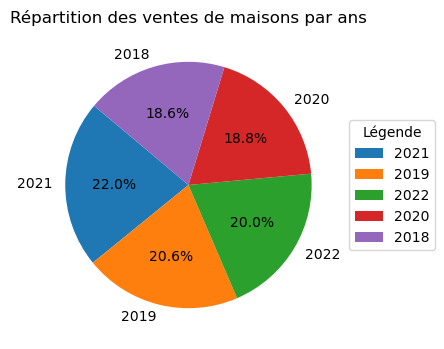

In [31]:
value_counts = df_maisons['year'].value_counts()

# Créez un diagramme circulaire
plt.figure(figsize=(4, 4))  # Facultatif : ajustez la taille du diagramme
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=140)

# Ajoutez un titre
plt.title("Répartition des ventes de maisons par ans")
plt.legend(title="Légende", loc="center left", bbox_to_anchor=(1, 0.5))
# Affichez le diagramme
plt.show()

Concaténation sur les dataframes des appartements vendus

In [32]:
dataframes = [df_appartements_2018, df_appartements_2019, df_appartements_2020, df_appartements_2021, df_appartements_2022]

df_appartements = pd.concat(dataframes, ignore_index=True)
df_appartements['date_mutation'] = pd.to_datetime(df_appartements['date_mutation'], format='%Y-%m-%d', errors='coerce')   
df_appartements['year'] = df_appartements['date_mutation'].dt.year
df_appartements.head()

,date_mutation,nb_elements,valeur_fonciere,code_commune,nom_commune,surface_reelle_bati,somme_terrain,local_dependance,local_terrain,nombre_pieces_principales,l_code_nature_culture,l_code_nature_culture_speciale,prix_m_carre,prix_mcarr_moy_ville,year
0,2018-08-22,2,115000.0,91016,Angerville,66.0,0.0,1,0,3.0,{PDC},{PDCS},1742.424242,1559.556787,2018
1,2018-05-25,2,125000.0,91016,Angerville,65.0,0.0,1,0,3.0,{PDC},{PDCS},1923.076923,1559.556787,2018
2,2018-05-04,2,135000.0,91016,Angerville,100.0,0.0,1,0,2.0,{PDC},{PDCS},1350.000000,1559.556787,2018
3,2018-04-03,1,83000.0,91016,Angerville,70.0,0.0,0,0,3.0,{PDC},{PDCS},1185.714286,1559.556787,2018
4,2018-01-19,2,105000.0,91016,Angerville,60.0,0.0,1,0,3.0,{PDC},{PDCS},1750.000000,1559.556787,2018


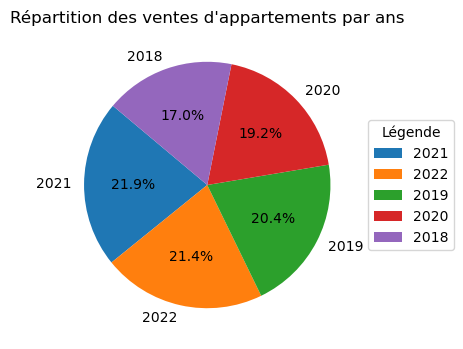

In [33]:
value_counts = df_appartements['year'].value_counts()

# Créez un diagramme circulaire
plt.figure(figsize=(4, 4))  # Facultatif : ajustez la taille du diagramme
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=140)

# Ajoutez un titre
plt.title("Répartition des ventes d'appartements par ans")
plt.legend(title="Légende", loc="center left", bbox_to_anchor=(1, 0.5))
# Affichez le diagramme
plt.show()

Sauvegardes des dataframes maisons et appartements vendus

In [34]:
chemin_du_fichier_csv = r"../data/df_maisons_2018_to_2022_91.csv"

df_maisons.to_csv(chemin_du_fichier_csv, index=False) 

chemin_du_fichier_csv = r"../data/df_appartements_2018_to_2022_91.csv"

df_appartements.to_csv(chemin_du_fichier_csv, index=False) 

Chargement des dataframes créés précédemment pour accélerer la lecture par la suite

In [35]:
df_appartements = pd.read_csv(r"../data/df_appartements_2018_to_2022_91.csv")
df_maisons = pd.read_csv(r"../data/df_maisons_2018_to_2022_91.csv")

## II- Graphique des évolutions entre 2018 et 2022

Pour plus de lisibilité sur les graphiques, on va trier les maisons et les appartements et se concentrer sur les biens qui ont & pièce principale ou plus, dont la surface est supérieure à 10 m² et dont la valeur financière est supérieure à 10 000 € et inférieure à 10 000 000 € (erreur de frappe possible dans la saisie des données)

In [36]:
df_maisons = df_maisons[(df_maisons['nombre_pieces_principales'] != 0) & (df_maisons['surface_reelle_bati'] > 10) & (df_maisons['valeur_fonciere'] > 10000) & (df_maisons['valeur_fonciere'] < 10000000)]
df_appartements = df_appartements[(df_appartements['nombre_pieces_principales'] != 0) & (df_appartements['surface_reelle_bati'] > 10) & (df_appartements['valeur_fonciere'] > 10000) & (df_appartements['valeur_fonciere'] < 10000000)]


On va reconcatener ces deux dataframes pour bien voir la différences entre les maisons et les appartements sur un même graphique

In [37]:
df_maisons['type_local'] = 'Maison'
df_appartements['type_local'] = 'Appartement'

In [38]:
dataframes = [df_appartements, df_maisons]

df_91 = pd.concat(dataframes, ignore_index=True)
df_91 = df_91.sort_values(by=['code_commune', 'date_mutation'])

In [39]:
chemin_du_fichier_csv = r"../data/df_2018_to_2022_91.csv"

df_91.to_csv(chemin_du_fichier_csv, index=False)

In [40]:
df_91 = pd.read_csv(r"../data/df_2018_to_2022_91.csv")

Proportion du nombre de pièces dans les biens vendus

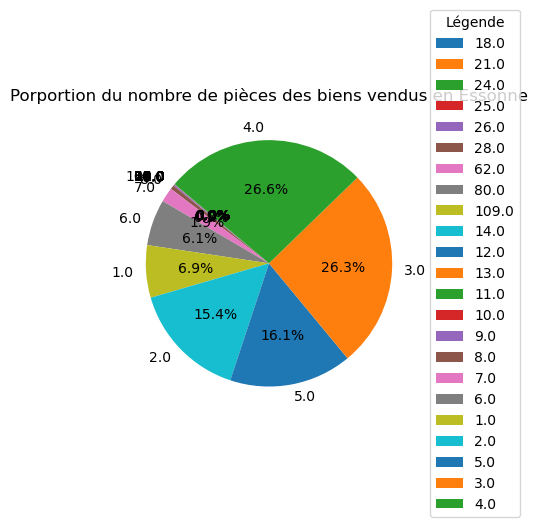

In [41]:
value_counts = df_91['nombre_pieces_principales'].value_counts()

sorted_data = sorted(zip(value_counts, value_counts.index))
valeurs, categories = zip(*sorted_data)

plt.figure(figsize=(4, 4))  
plt.pie(valeurs, labels=categories, autopct='%1.1f%%', startangle=140)

# Ajoutez un titre
plt.title("Porportion du nombre de pièces des biens vendus en Essonne")
plt.legend(title="Légende", loc="center left", bbox_to_anchor=(1, 0.5))
# Affichez le diagramme
plt.show()

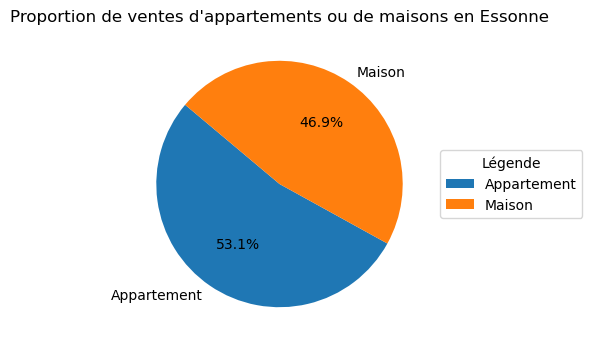

In [42]:
value_counts = df_91['type_local'].value_counts()

plt.figure(figsize=(4, 4))  
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=140)

# Ajoutez un titre
plt.title("Proportion de ventes d'appartements ou de maisons en Essonne")
plt.legend(title="Légende", loc="center left", bbox_to_anchor=(1, 0.5))
# Affichez le diagramme
plt.show()

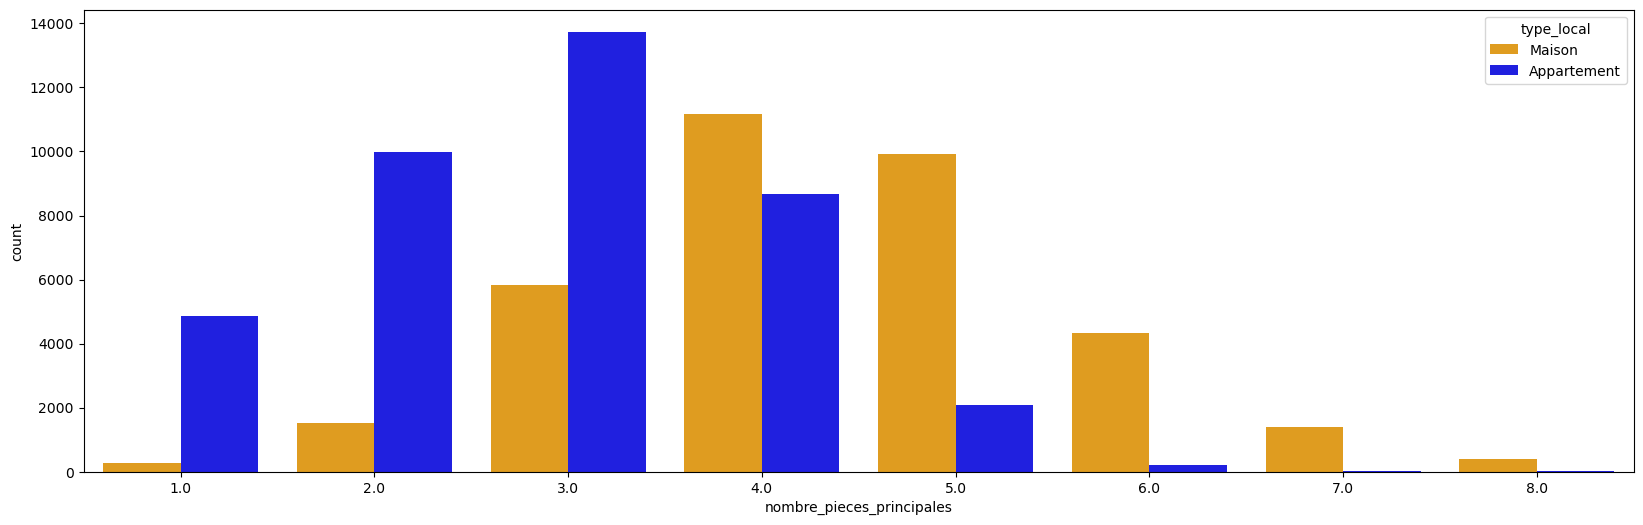

In [45]:
palette = {'Appartement': 'blue', 'Maison': 'orange'}
sns.countplot(data=df_91[df_91['nombre_pieces_principales']<9], x='nombre_pieces_principales', hue='type_local', palette=palette)

plt.gcf().set_size_inches(20, 6)
plt.show()

Répartition des maisons et appartements selon leur nombre de pièces principales


---

Graphique représentant le prix moyen du mêtre carré en Essonne au cours des mois de 2018 à 2022 

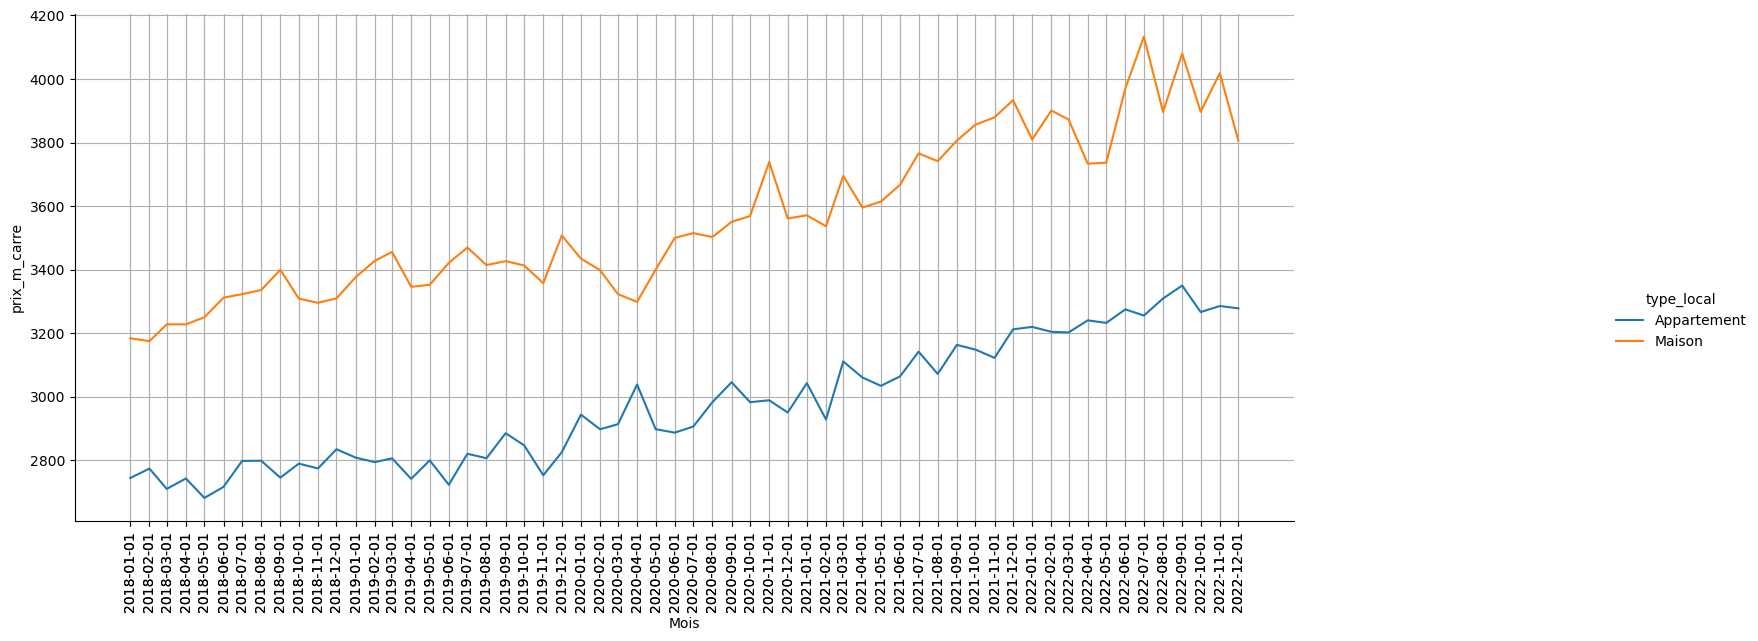

In [46]:
df_91['date_mutation'] = pd.to_datetime(df_91['date_mutation'])

# On créé un dataframe qui va calculer le prix moyen des biens vendus dans un mois
df_grouped_moyenne = df_91.groupby([df_91['date_mutation'].dt.to_period('M'), 'type_local'])['prix_m_carre'].mean().reset_index()

# On renome la colonne Mois pour la concaténation
df_grouped_moyenne.rename(columns={'date_mutation': 'Mois'}, inplace=True)

# ON créer un dataframe qui a prendre le nombre de biens vendus dans un mois
df_grouped_taille = df_91.groupby([df_91['date_mutation'].dt.to_period('M'), 'type_local'])['prix_m_carre'].size().reset_index(name='Comptage')

# On renome la colonne Mois pour la concaténation
df_grouped_taille.rename(columns={'date_mutation': 'Mois'}, inplace=True)

# COncaténation des dataframes précédents
df_grouped = pd.merge(df_grouped_moyenne, df_grouped_taille, on=['Mois', 'type_local'], how='left')

df_grouped['Mois'] = df_grouped['Mois'].dt.to_timestamp()


#Affichage
sns.relplot(data = df_grouped, 
            x='Mois', 
            y = 'prix_m_carre',
            hue ='type_local',
            kind = 'line')

plt.xticks(df_grouped['Mois'],rotation=90)
plt.grid(True)
plt.gcf().set_size_inches(20, 6)
plt.show();

Graphique représentant le nombre de biens vendus en Essonne au cours des mois de 2018 à 2022 , diférenciant maisons et appartements

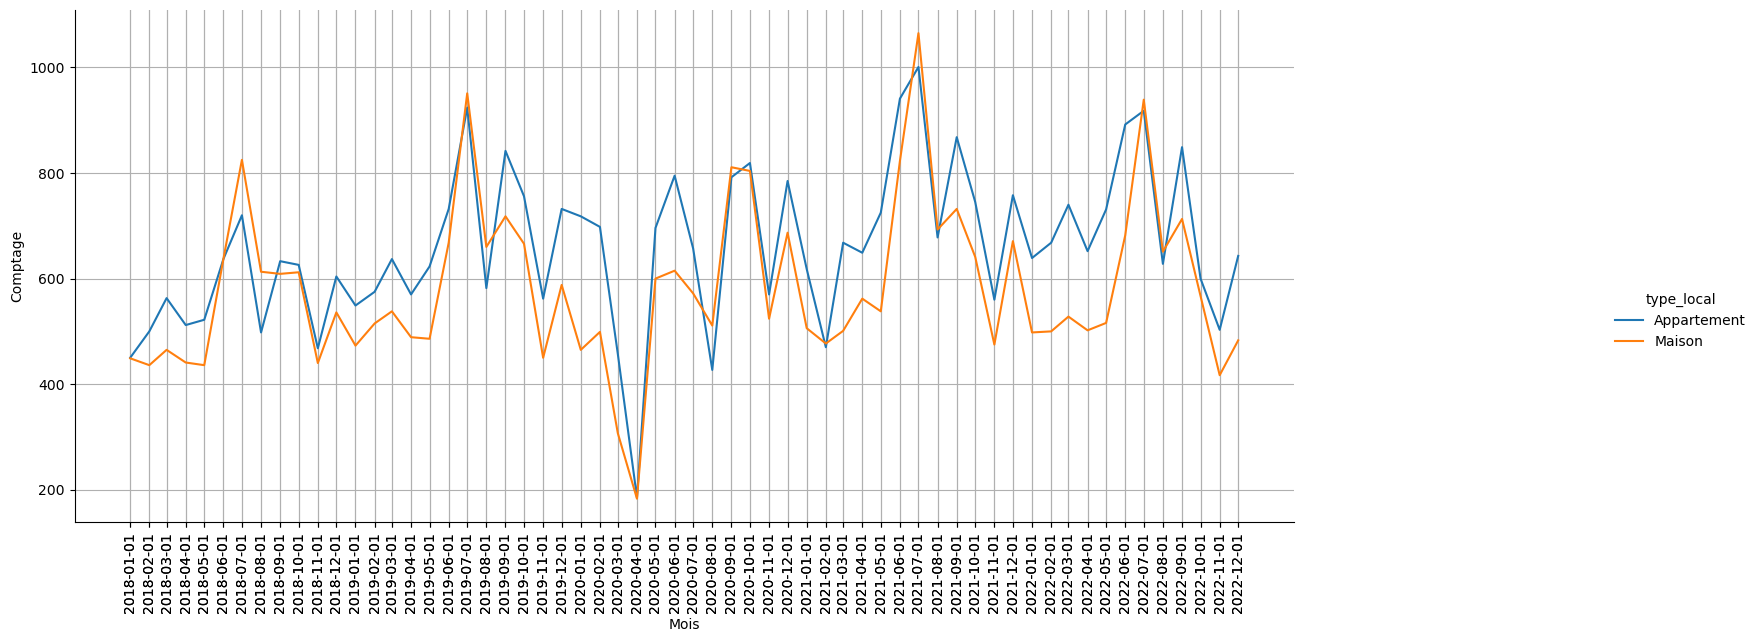

In [47]:
sns.relplot(data = df_grouped, 
            x='Mois', 
            y = 'Comptage',
            hue ='type_local',
            kind = 'line')

plt.xticks(df_grouped['Mois'],rotation=90)
plt.grid(True)
plt.gcf().set_size_inches(20, 6)

plt.show();

Graphique représentant le nombre de biens vendus en Essonne au cours des mois de 2018 à 2022

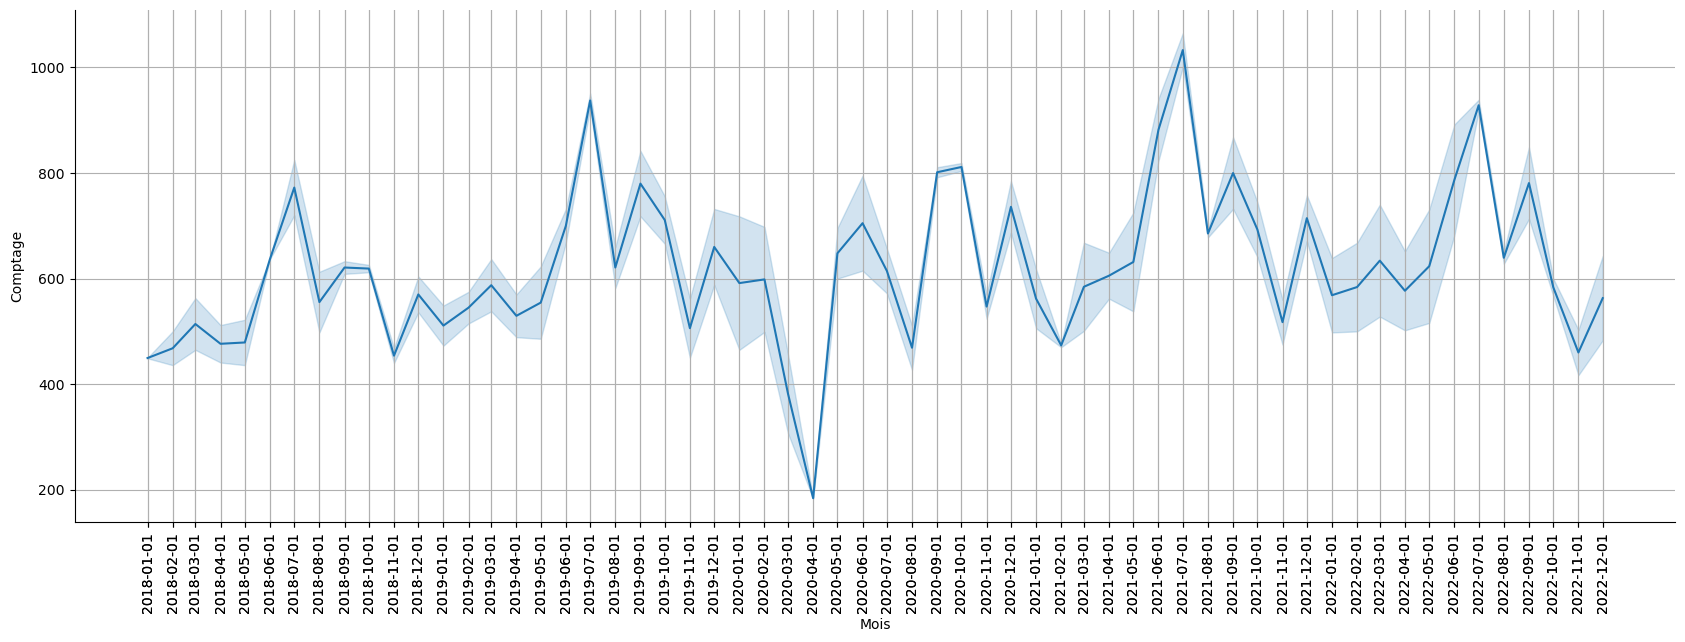

In [48]:
sns.relplot(data = df_grouped, 
            x='Mois', 
            y = 'Comptage',
            kind = 'line')

plt.xticks(df_grouped['Mois'],rotation=90)
plt.grid(True)
plt.gcf().set_size_inches(20, 6)

plt.show();

Evolution des prix en fonction du nombre de pièces, en fonction de la surface du batiment

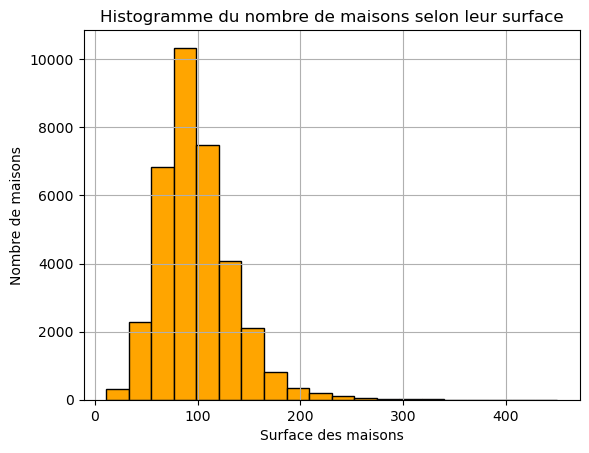

In [49]:
plt.hist(df_maisons['surface_reelle_bati'], bins=20, color='orange', edgecolor='black')

# Personnalisez le graphique
plt.title('Histogramme du nombre de maisons selon leur surface')
plt.xlabel('Surface des maisons')
plt.ylabel('Nombre de maisons')
plt.grid(True)

# Affichez le graphique
plt.show()

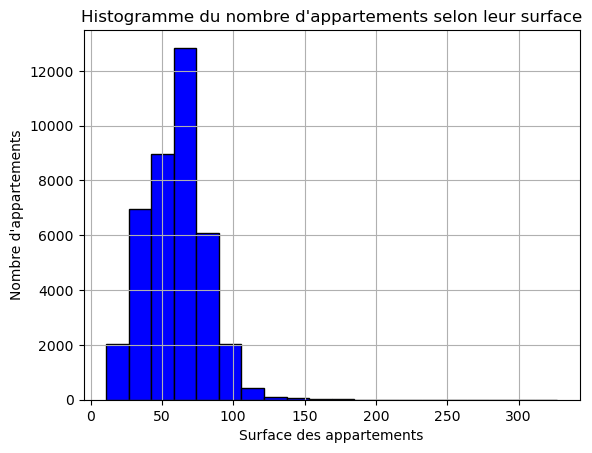

In [50]:
plt.hist(df_appartements['surface_reelle_bati'], bins=20, color='blue', edgecolor='black')

# Personnalisez le graphique
plt.title("Histogramme du nombre d'appartements selon leur surface")
plt.xlabel('Surface des appartements')
plt.ylabel("Nombre d'appartements")
plt.grid(True)

# Affichez le graphique
plt.show()

Evolution des prix au m² en fonction du nombre de pièces principales

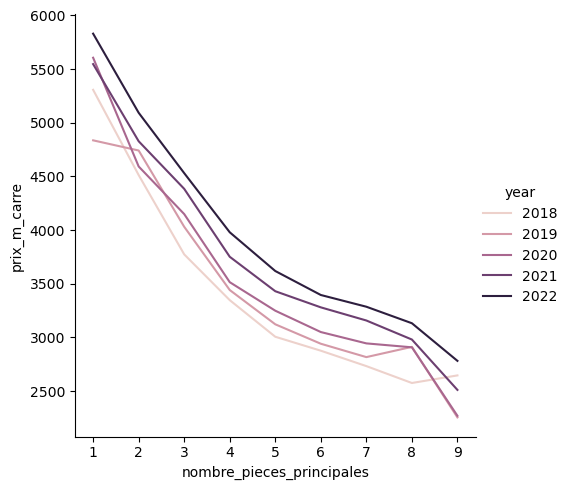

In [51]:
sns.relplot(data = df_maisons[df_maisons['nombre_pieces_principales']<10], 
                         x='nombre_pieces_principales' , 
                         y = 'prix_m_carre', 
                         hue = 'year',
                           kind = 'line',
           ci =None);

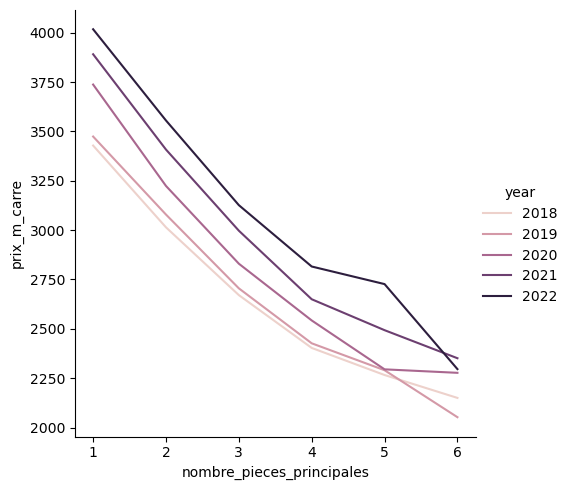

In [53]:
sns.relplot(data = df_appartements[df_appartements['nombre_pieces_principales']<7], 
                         x='nombre_pieces_principales' , 
                         y = 'prix_m_carre', 
                         hue = 'year',
                           kind = 'line',
           ci =None);

Courbes représentant les prix en fonction de la surface réelle pour les maisons puis pour les appartements

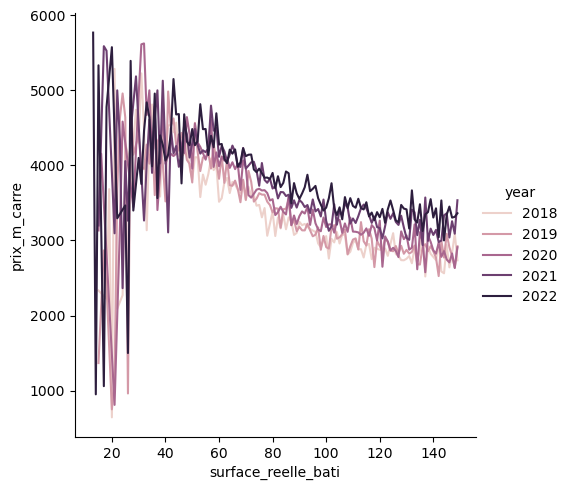

In [54]:
sns.relplot(data = df_maisons[(df_maisons['surface_reelle_bati']<150) &(df_maisons['prix_m_carre']<6000)], 
                         x='surface_reelle_bati' , 
                         y = 'prix_m_carre', 
                         hue = 'year',
                           kind = 'line',
           ci =None);



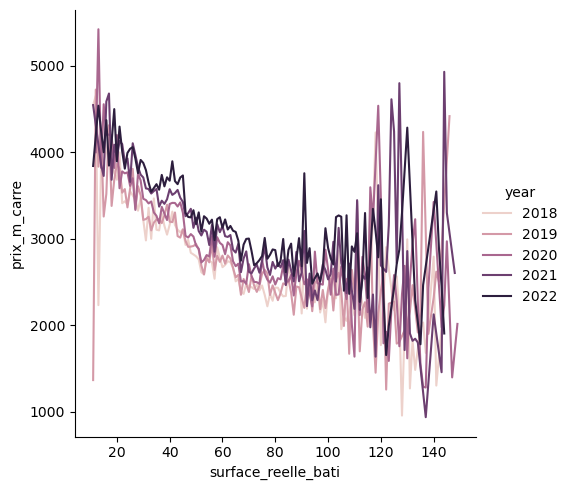

In [55]:
sns.relplot(data = df_appartements[(df_appartements['surface_reelle_bati']<150) & (df_appartements['prix_m_carre']<6000)], 
                         x='surface_reelle_bati' , 
                         y = 'prix_m_carre', 
                         hue = 'year',
                           kind = 'line',
           ci =None);

Pour plus de précision dans ces graphiques, il faudrait faire une moyenne des prix au m² pour un intervalle de surface, mais on peut déjà faire quelques observations: 
* Les prix au m² décroient en fonction du nombre de pièces
* Les prix au m² décroient en fonction de la surface
* Les prix au m² ont aumentés au fur des années

# III - Et sur Massy, ville du 91

Le choix du 91 n'a pas été un hasard, c'est le département où j'ai toujours vécu. Récemment installé à Massy, qu'en est-il pour cette ville ?    

In [56]:
df_Massy = df_91[df_91['nom_commune']=='Massy']
df_Massy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2776 entries, 37612 to 40387
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   date_mutation                   2776 non-null   datetime64[ns]
 1   nb_elements                     2776 non-null   int64         
 2   valeur_fonciere                 2776 non-null   float64       
 3   code_commune                    2776 non-null   int64         
 4   nom_commune                     2776 non-null   object        
 5   surface_reelle_bati             2776 non-null   float64       
 6   somme_terrain                   2776 non-null   float64       
 7   local_dependance                2776 non-null   int64         
 8   local_terrain                   2776 non-null   int64         
 9   nombre_pieces_principales       2776 non-null   float64       
 10  l_code_nature_culture           2776 non-null   object        
 11 

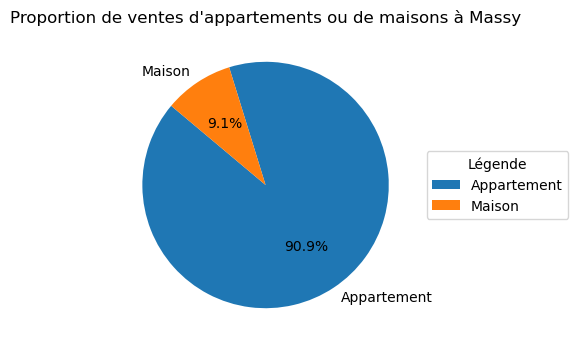

In [57]:
value_counts = df_Massy['type_local'].value_counts()

plt.figure(figsize=(4, 4))  
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=140)

# Ajoutez un titre
plt.title("Proportion de ventes d'appartements ou de maisons à Massy")
plt.legend(title="Légende", loc="center left", bbox_to_anchor=(1, 0.5))
# Affichez le diagramme
plt.show()

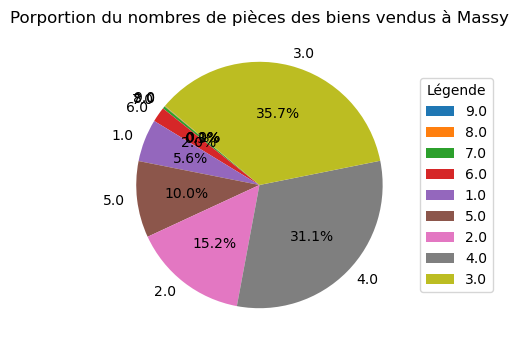

In [58]:
value_counts = df_Massy['nombre_pieces_principales'].value_counts()

sorted_data = sorted(zip(value_counts, value_counts.index))
valeurs, categories = zip(*sorted_data)

plt.figure(figsize=(4, 4))  
plt.pie(valeurs, labels=categories, autopct='%1.1f%%', startangle=140)

# Ajoutez un titre
plt.title("Porportion du nombres de pièces des biens vendus à Massy")
plt.legend(title="Légende", loc="center left", bbox_to_anchor=(1, 0.5))
# Affichez le diagramme
plt.show()

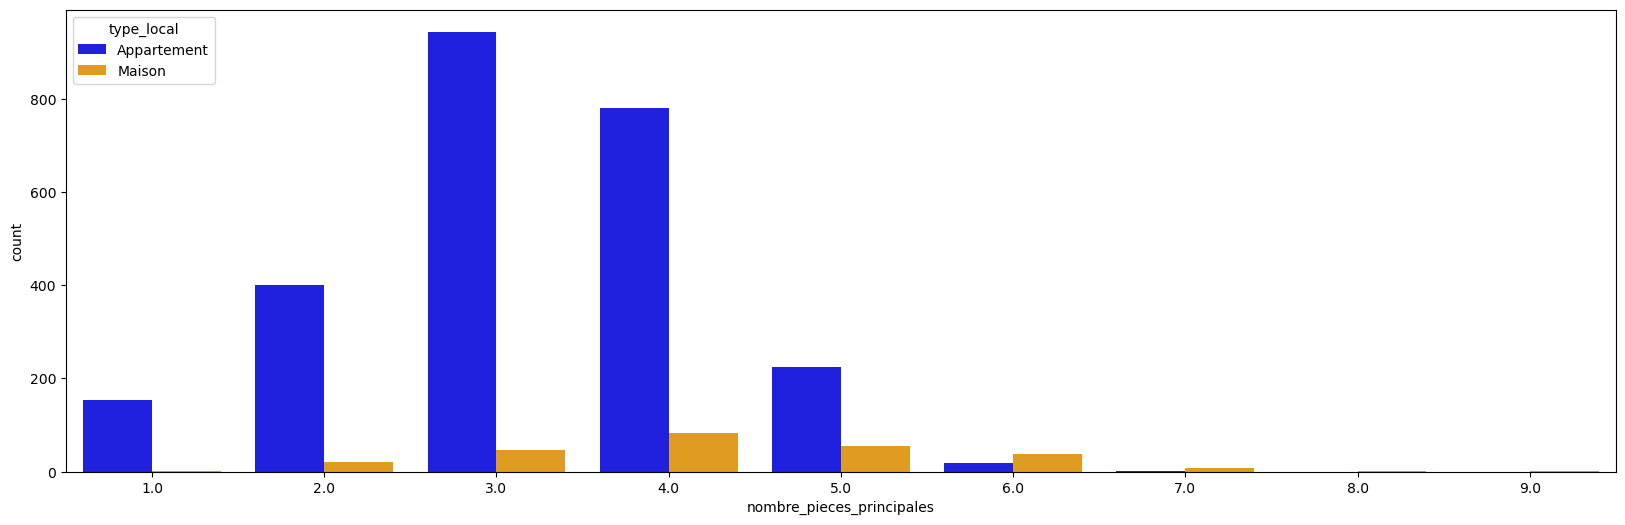

In [59]:
palette = {'Appartement': 'blue', 'Maison': 'orange'}
sns.countplot(data=df_Massy, x='nombre_pieces_principales', hue='type_local', palette=palette)

plt.gcf().set_size_inches(20, 6)
plt.show()

C:\Users\julie\AppData\Local\Temp\ipykernel_5460\957183874.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Massy['date_mutation'] = pd.to_datetime(df_Massy['date_mutation'])


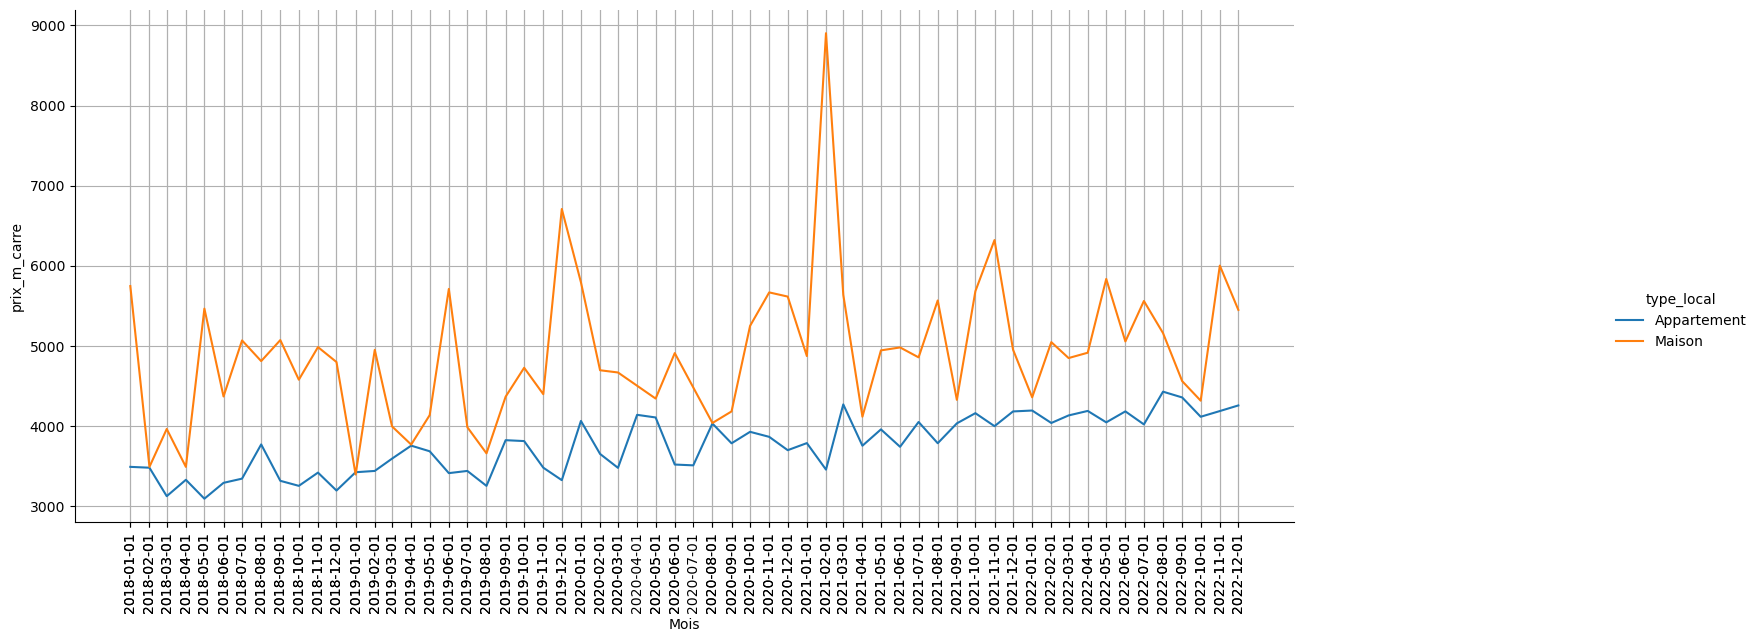

In [60]:
df_Massy['date_mutation'] = pd.to_datetime(df_Massy['date_mutation'])

# On créé un dataframe qui va calculer le prix moyen des biens vendus dans un mois
df_grouped_moyenne = df_Massy.groupby([df_Massy['date_mutation'].dt.to_period('M'), 'type_local'])['prix_m_carre'].mean().reset_index()

# On renome la colonne Mois pour la concaténation
df_grouped_moyenne.rename(columns={'date_mutation': 'Mois'}, inplace=True)

# ON créer un dataframe qui a prendre le nombre de biens vendus dans un mois
df_grouped_taille = df_Massy.groupby([df_91['date_mutation'].dt.to_period('M'), 'type_local'])['prix_m_carre'].size().reset_index(name='Comptage')

# On renome la colonne Mois pour la concaténation
df_grouped_taille.rename(columns={'date_mutation': 'Mois'}, inplace=True)

# COncaténation des dataframes précédents
df_grouped = pd.merge(df_grouped_moyenne, df_grouped_taille, on=['Mois', 'type_local'], how='left')

df_grouped['Mois'] = df_grouped['Mois'].dt.to_timestamp()


#Affichage
sns.relplot(data = df_grouped, 
            x='Mois', 
            y = 'prix_m_carre',
            hue ='type_local',
            kind = 'line')

plt.xticks(df_grouped['Mois'],rotation=90)
plt.grid(True)
plt.gcf().set_size_inches(20, 6)
plt.show();

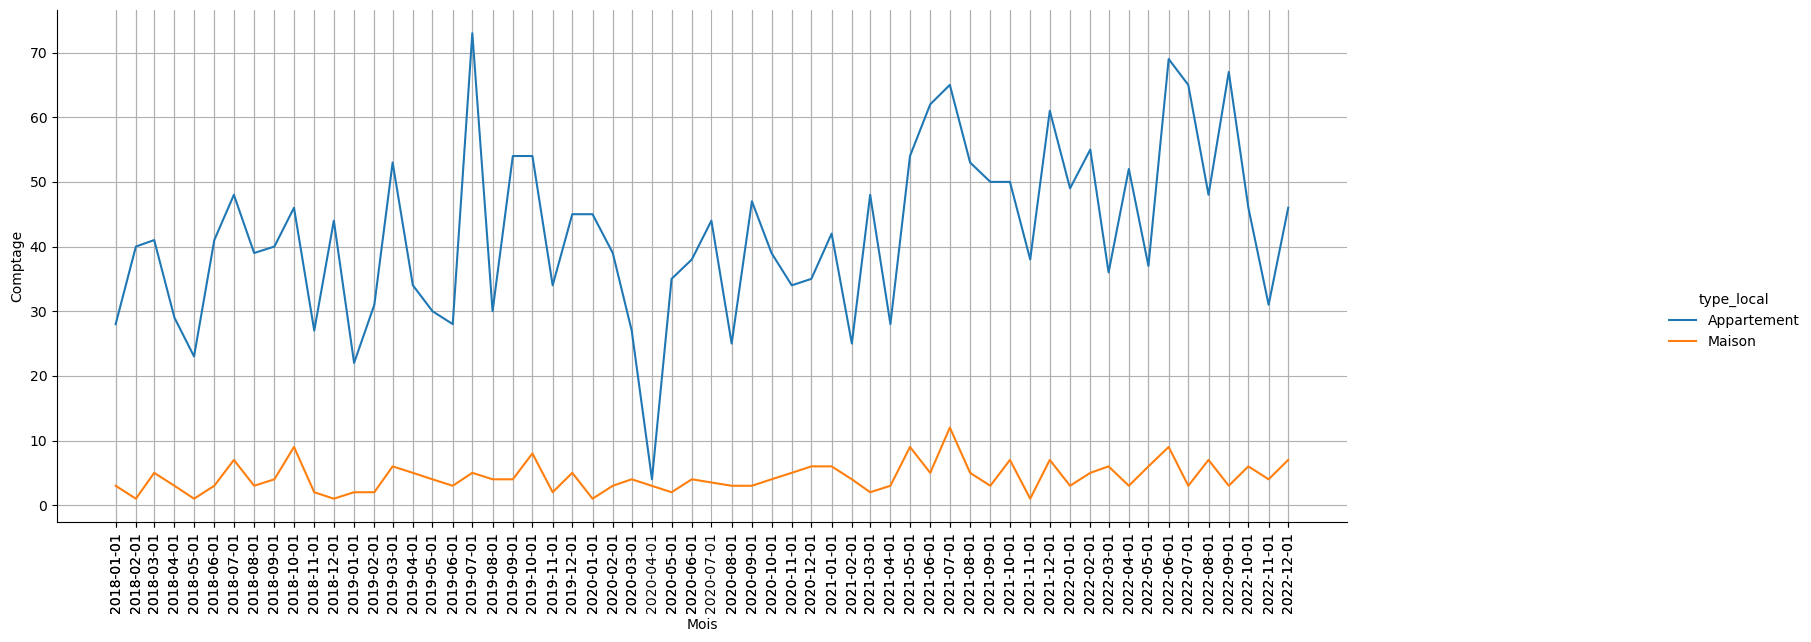

In [61]:
sns.relplot(data = df_grouped, 
            x='Mois', 
            y = 'Comptage',
            hue ='type_local',
            kind = 'line')

plt.xticks(df_grouped['Mois'],rotation=90)
plt.grid(True)
plt.gcf().set_size_inches(20, 6)

plt.show();

Il est assez clair que Massy est une ville où la vente d'appartements est beaucoup plus élevé que la vente de Maison. Celà s'explique aussi par un grand nombre de projets de construction, qui sont principalement des immeubles, dans des zones proches de transports en communs, et developpées. D'où l'augmentation des prix au m² des appartements qui arivent au dessu du prixx moyen du déppartement (environ 4 200€ à Massy pour 3 200€ en Essonne)

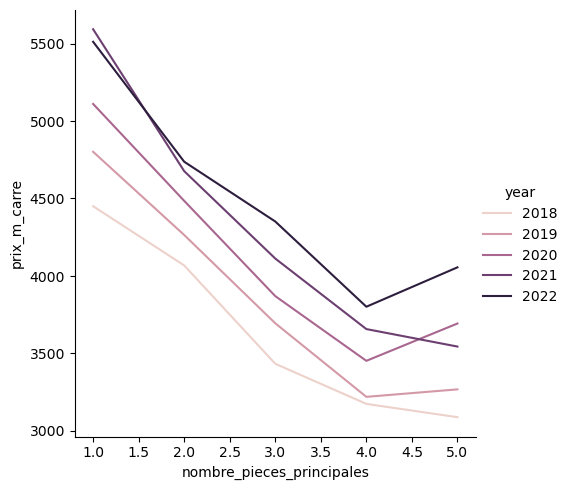

In [62]:
sns.relplot(data = df_Massy[df_Massy['nombre_pieces_principales']<6], 
                         x='nombre_pieces_principales' , 
                         y = 'prix_m_carre', 
                         hue = 'year',
                           kind = 'line',
           ci =None);

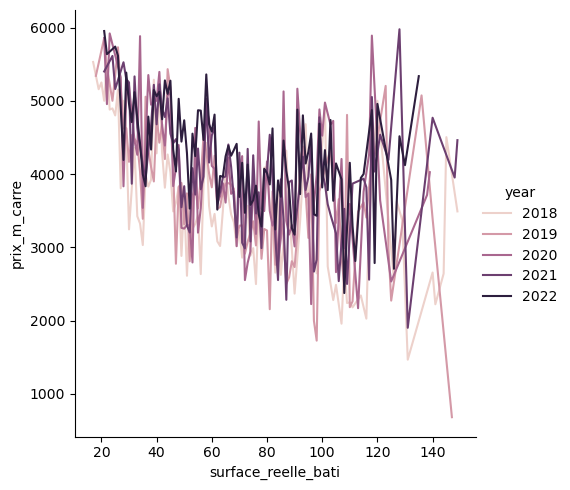

In [63]:
sns.relplot(data = df_Massy[(df_Massy['surface_reelle_bati']<150) & (df_Massy['prix_m_carre']<6000)], 
                         x='surface_reelle_bati' , 
                         y = 'prix_m_carre', 
                         hue = 'year',
                           kind = 'line',
           ci =None);

Encore une fois ce graphique pourrait être plus lisible, mais on voit bien l'augmentation des prix au mé au cours des années

## Conclusion

Les différents graphiques présentés nous permettent de faire des conclusio sur les évolutions des variables au cours des années. Ils nous permettent aussi de voir les corrélations que le prix au m² peut avoir avec la surface du bien, son nombre de pièce, si c'est une maison ou un appartement. Mais aussi avec la ville dans laquelle se situe le bien, les prix à Massy sont supérieurs aux prix moyens de l'Essonne.